In [ ]:
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, label = self.data_df.iloc[idx]['img_num'], self.data_df.iloc[idx]['number_of_houses']

        # читаем картинку. read the image
        image = cv2.imread(f"/content/train/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label).long()
    
    def __len__(self):
        return len(self.data_df)

In [ ]:
# задаем преобразование изображения.

train_transform = transforms.Compose([
    transforms.Resize(256),
    #transforms.RandomResizedCrop(224),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    #transforms.RandomResizedCrop(224),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [ ]:
# читаем датасет
data_df = pd.read_csv("/content/train.csv")

In [ ]:
data_df2 = pd.read_csv("/content/train3.csv")
data_df2 = data_df2.drop(["id"], axis = 1)
data_df = data_df.append(data_df2, ignore_index=True) 
data_df

,img_num,number_of_houses
0,000000000611.jpg,9
1,000000000530.jpg,10
2,000000002787.jpg,10
3,000000000049.jpg,2
4,000000001883.jpg,9
...,...,...
4195,1000000001638.jpg,11
4196,1000000001095.jpg,16
4197,1000000001130.jpg,8
4198,1000000001294.jpg,8


In [ ]:
data_df3 = pd.read_csv("/content/train5.csv")
data_df3 = data_df3.drop(["id"], axis = 1)
data_df = data_df.append(data_df3, ignore_index=True) 
data_df

,img_num,number_of_houses
0,000000000611.jpg,9
1,000000000530.jpg,10
2,000000002787.jpg,10
3,000000000049.jpg,2
4,000000001883.jpg,9
...,...,...
6295,2000000001638.jpg,11
6296,2000000001095.jpg,16
6297,2000000001130.jpg,8
6298,2000000001294.jpg,8


In [ ]:
# Нам придется вычесть 1 что индексы классов начинались с 0.
data_df.number_of_houses = data_df.number_of_houses- 1
# Главное потом не забыть прибавить ее обратно

In [ ]:
data_df.head(3)

,img_num,number_of_houses
0,000000000611.jpg,8
1,000000000530.jpg,9
2,000000002787.jpg,9


In [ ]:
!unzip train.zip

Archive:  train.zip
   creating: train/
  inflating: train/000000000040.jpg  
  inflating: train/000000000078.jpg  
  inflating: train/000000000083.jpg  
  inflating: train/000000000084.jpg  
  inflating: train/000000000103.jpg  
  inflating: train/000000000106.jpg  
  inflating: train/000000000114.jpg  
  inflating: train/000000000222.jpg  
  inflating: train/000000000241.jpg  
  inflating: train/000000000264.jpg  
  inflating: train/000000000273.jpg  
  inflating: train/000000000294.jpg  
  inflating: train/000000000301.jpg  
  inflating: train/000000000302.jpg  
  inflating: train/000000000323.jpg  
  inflating: train/000000000327.jpg  
  inflating: train/000000000380.jpg  
  inflating: train/000000000428.jpg  
  inflating: train/000000000470.jpg  
  inflating: train/000000000475.jpg  
  inflating: train/000000000489.jpg  
  inflating: train/000000000492.jpg  
  inflating: train/000000000539.jpg  
  inflating: train/000000000575.jpg  
  inflating: train/000000000588.jpg  
  inflatin

In [ ]:
!unzip train2.zip

Archive:  train2.zip
   creating: train2/
  inflating: train2/1000000000053.jpg  
  inflating: train2/1000000000054.jpg  
  inflating: train2/1000000000068.jpg  
  inflating: train2/1000000000187.jpg  
  inflating: train2/1000000000213.jpg  
  inflating: train2/1000000000281.jpg  
  inflating: train2/1000000000307.jpg  
  inflating: train2/1000000000327.jpg  
  inflating: train2/1000000000385.jpg  
  inflating: train2/1000000000389.jpg  
  inflating: train2/1000000000392.jpg  
  inflating: train2/1000000000397.jpg  
  inflating: train2/1000000000502.jpg  
  inflating: train2/1000000000592.jpg  
  inflating: train2/1000000000633.jpg  
  inflating: train2/1000000000696.jpg  
  inflating: train2/1000000000745.jpg  
  inflating: train2/1000000000777.jpg  
  inflating: train2/1000000000791.jpg  
  inflating: train2/1000000000841.jpg  
  inflating: train2/1000000000878.jpg  
  inflating: train2/1000000000882.jpg  
  inflating: train2/1000000000901.jpg  
  inflating: train2/1000000001040.jpg 

In [ ]:
!unzip train3.zip

Archive:  train3.zip
replace train3/000000000040.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
cp /content/train2/* /content/train

In [ ]:
cp /content/train3/* /content/train

In [ ]:
!unzip test.zip

Archive:  test.zip
   creating: test/
  inflating: test/000000000134.jpg   
  inflating: test/000000000135.jpg   
  inflating: test/000000000157.jpg   
  inflating: test/000000000170.jpg   
  inflating: test/000000000173.jpg   
  inflating: test/000000000178.jpg   
  inflating: test/000000000231.jpg   
  inflating: test/000000000257.jpg   
  inflating: test/000000000266.jpg   
  inflating: test/000000000288.jpg   
  inflating: test/000000000289.jpg   
  inflating: test/000000000322.jpg   
  inflating: test/000000000331.jpg   
  inflating: test/000000000332.jpg   
  inflating: test/000000000381.jpg   
  inflating: test/000000000411.jpg   
  inflating: test/000000000424.jpg   
  inflating: test/000000000439.jpg   
  inflating: test/000000000456.jpg   
  inflating: test/000000000495.jpg   
  inflating: test/000000000507.jpg   
  inflating: test/000000000528.jpg   
  inflating: test/000000000535.jpg   
  inflating: test/000000000553.jpg   
  inflating: test/000000000594.jpg   
  inflating:

In [ ]:
from os import listdir

print("Обучающей выборки " ,len(listdir("/content/train")))
print("Обогащенной обучающей выборки " ,len(listdir("/content/train2")) + len(listdir("/content/train3")))
print("Тестовой выборки " ,len(listdir("/content/test")))

Обучающей выборки  4200
Обогащенной обучающей выборки  4200
Тестовой выборки  900


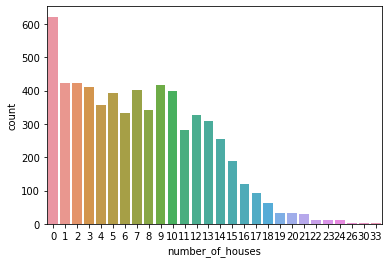

In [ ]:
import seaborn as sns
import warnings

warnings.simplefilter('ignore')
sns.countplot(x = "number_of_houses" , data  = data_df)

Обратим внимание, что после 24 домов идет 26 и 30. В данных идут пропуски которые могут вызвать вызвать ошибки у CUDA. Выкинем такие данные.

In [ ]:
data_df = data_df[data_df.number_of_houses < 25]

In [ ]:
data_df.number_of_houses.unique()

array([ 8,  9,  1,  2, 10, 11,  5, 15, 16,  0, 14,  3,  6,  7, 20, 13, 12,
        4, 17, 21, 19, 18, 24, 22, 23])

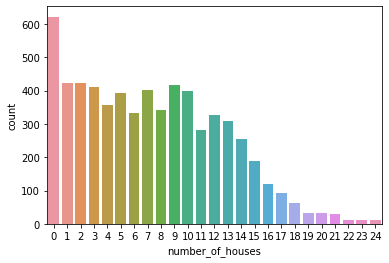

In [ ]:
sns.countplot(x = "number_of_houses" , data  = data_df)

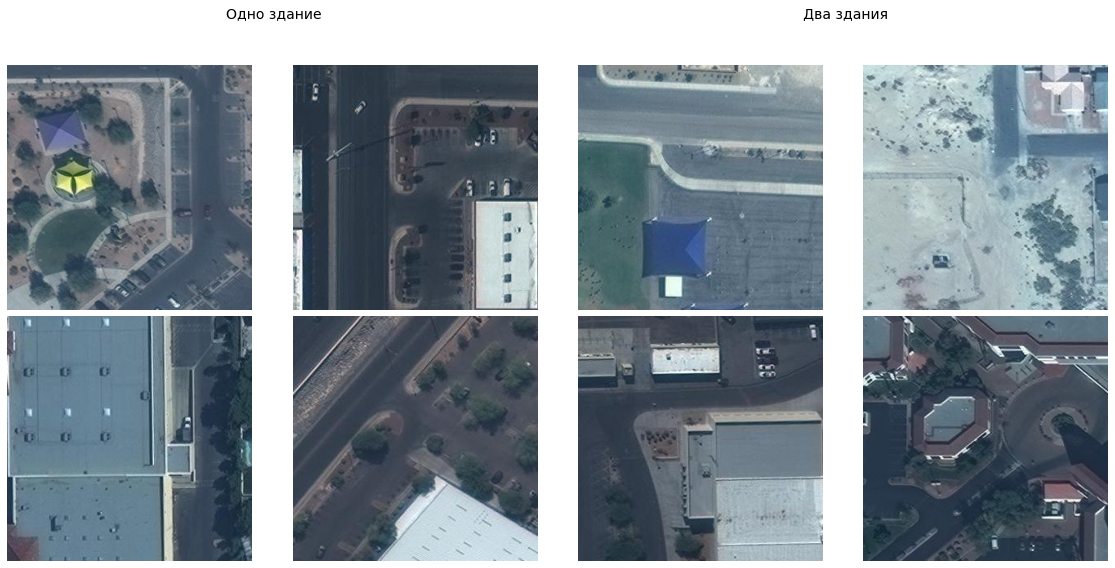

In [ ]:
# посмотрим на картинки. let's look at the images

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Одно здание {" "*105} Два здания', fontsize=14)

for i, name in zip(range(4), data_df[ data_df['number_of_houses'] == 1 ].sample(4, random_state=42)['img_num']):
    axs[i // 2, (i % 2)].imshow(plt.imread(f"/content/train/{name}"))
    axs[i // 2, (i % 2)].axis('off')

for i, name in zip(range(4), data_df[ data_df['number_of_houses'] == 2 ].sample(4, random_state=42)['img_num']):
    axs[i // 2, (i % 2)+2].imshow(plt.imread(f"/content/train/{name}"))
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [ ]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(data_df, test_size=0.2, random_state=43)

In [ ]:
train_df.shape, valid_df.shape

((5032, 2), (1259, 2))

In [ ]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=16,
                                           #shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

## Вспомогательные функции

In [ ]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [ ]:
def train_(epocs, loader, model, valid_set, early_stop):
    best_v_acc = 0.0
    bad_rds = 0
    for epoch in range(epocs):  # loop over the dataset multiple times
        print("Training...")
        correct = 0
        total = 0
        running_loss = 0.0
        for i, data in enumerate(loader, 0):
            model.train()
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss=criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            max_index = outputs.max(dim = 1)[1]
            correct += (max_index == labels).sum().item()
            total += labels.size(0)

            
            # print statistics
            running_loss += loss.item()
            if i % len(loader) == len(loader) - 1:    
                print('[epoc: %d, %5d] training loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / len(loader)))
                running_loss = 0.0
        print("Training Accuracy = {}".format(100 * correct / total))
        
        
        correct = 0
        total = 0
        running_loss = 0.0
        print("Validating...")
        for i, data in enumerate(valid_set, 0):
            model.eval()
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
                outputs = model(inputs)
                loss=criterion(outputs, labels)
                max_index = outputs.max(dim = 1)[1]
                correct += (max_index == labels).sum().item()
                total += labels.size(0)
                
                # print statistics
                running_loss += loss.item()
                if i % len(valid_set) == len(valid_set) - 1:    
                    print('[epoc: %d, %5d] valid loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / len(loader)))
                    running_loss = 0.0
                    
        if (100 * correct / total) > best_v_acc:
            best_v_acc = 100 * correct / total
            print("BEST MODEL SAVED")
            torch.save(model.state_dict(), 'best_model.pt')
            bad_rds = 0
        else:
            bad_rds += 1
        print("\nvalid Accuracy = {}".format(100 * correct / total))
        
        if bad_rds == early_stop:
            print("EARLY STOPPING AFTER ", bad_rds, " BAD ROUNDS")
            return 


## Модель

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Подргружаем модель

model = models.resnet101(pretrained=True)
model.fc = nn.Linear(2048, 25)

model = model.cuda()

criterion = torch.nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.34E-04


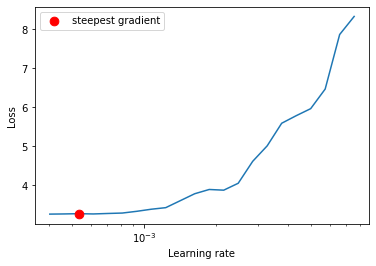

In [ ]:
optimizer = torch.optim.RMSprop(model.fc.parameters(), lr=0.0001)
!pip install torch-lr-finder
from torch_lr_finder import LRFinder
lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot()
lr_finder.reset()

In [ ]:
train_(100, train_loader, model, valid_loader, 10)

Training...
[epoc: 1,   315] training loss: 2.811
Training Accuracy = 14.686009538950715
Validating...
[epoc: 1,    79] valid loss: 0.678
BEST MODEL SAVED

valid Accuracy = 16.12390786338364
Training...
[epoc: 2,   315] training loss: 2.616
Training Accuracy = 18.93879173290938
Validating...
[epoc: 2,    79] valid loss: 0.646
BEST MODEL SAVED

valid Accuracy = 20.889594916600476
Training...
[epoc: 3,   315] training loss: 2.503
Training Accuracy = 23.032591414944356
Validating...
[epoc: 3,    79] valid loss: 0.623
BEST MODEL SAVED

valid Accuracy = 26.846703733121526
Training...
[epoc: 4,   315] training loss: 2.423
Training Accuracy = 25.059618441971384
Validating...
[epoc: 4,    79] valid loss: 0.612

valid Accuracy = 22.478157267672756
Training...
[epoc: 5,   315] training loss: 2.357
Training Accuracy = 27.384737678855327
Validating...
[epoc: 5,    79] valid loss: 0.601

valid Accuracy = 23.669579030976966
Training...
[epoc: 6,   315] training loss: 2.300
Training Accuracy = 29.232

In [ ]:
import gc

del train_loader #delete unnecessary variables 
gc.collect()

50

In [ ]:
import gc

del criterion #delete unnecessary variables 
gc.collect()

53

In [ ]:
import gc

del optimizer #delete unnecessary variables 
gc.collect()

100

In [ ]:
# вызов лучшей модели
model.load_state_dict(torch.load('best_model.pt'))
#
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Посмотрим метрики нашей итоговой модели на валидации.

In [ ]:
valid_predicts = []

for imgs, _ in tqdm(valid_loader):
    
    imgs = imgs.cuda()
    pred = model(imgs)

    pred_numpy = pred.cpu().detach().numpy()

    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      valid_predicts.append(index)

100%|██████████| 79/79 [00:16<00:00,  4.82it/s]


In [ ]:
valid_df["pred"] = valid_predicts

In [ ]:
valid_df

,img_num,number_of_houses,pred
4602,2000000000519.jpg,2,2
3062,1000000002727.jpg,12,7
4440,2000000001350.jpg,13,7
4827,2000000002434.jpg,8,5
3019,1000000000745.jpg,4,4
...,...,...,...
3490,1000000001329.jpg,7,7
3653,1000000000234.jpg,0,0
998,000000000501.jpg,12,12
3009,1000000002402.jpg,1,0


# Посчитаем accuracy

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc , accuracy_score

In [ ]:
valid_df['pred'].values

array([ 2,  7,  7, ..., 12,  0, 14])

In [ ]:
val_accuracy = accuracy_score(valid_df['number_of_houses'].values, valid_df['pred'].values)
print(f"Validation accuracy = {val_accuracy}")

Validation accuracy = 0.49722001588562353


## Предскажем для теста

In [ ]:
test_df = pd.read_csv("/content/sample_solution.csv")
test_df = test_df.drop(["number_of_houses"], axis = 1)

In [ ]:
class TestImageDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        image_name = self.data_df.iloc[idx]['img_num']
        
        # читаем картинку
        image = cv2.imread(f"/content/test/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно
        if self.transform:
            image = self.transform(image)
        
        return image
    
    def __len__(self):
        return len(self.data_df)

In [ ]:
test_dataset = TestImageDataset(test_df, valid_transform)

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=4,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=4)

In [ ]:
#import torch
#torch.cuda.empty_cache()

In [ ]:
#import gc

#del valid_loader #delete unnecessary variables 
#gc.collect()

#Предсказываем нашей моделью результат

In [75]:
model.load_state_dict(torch.load('best_model_best.pt'))
#
model.eval()
predicts = []

for imgs in tqdm(test_loader):
    
    imgs = imgs.cuda()
    pred = model(imgs)
    
    pred_numpy = pred.cpu().detach().numpy()
    
    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      predicts.append(index)
      #predicts.append(pred.softmax(dim=1)[:, 1].cpu().detach().numpy().argmax(1))

100%|██████████| 225/225 [00:38<00:00,  5.80it/s]


In [76]:
predicts[:5]

[12, 1, 12, 13, 3]

In [77]:
test_df.shape

(900, 2)

In [78]:
len(predicts)

900

In [79]:
test_df['number_of_houses'] = predicts 

In [80]:
test_df

,img_num,number_of_houses
0,000000001801.jpg,12
1,000000001190.jpg,1
2,000000001817.jpg,12
3,000000000251.jpg,13
4,000000002505.jpg,3
...,...,...
895,000000002443.jpg,5
896,000000000856.jpg,7
897,000000001983.jpg,2
898,000000000166.jpg,0


In [81]:
#Не забываем добавить 1 к предсказываемому лейблу
test_df['number_of_houses'] = test_df['number_of_houses'] +1

In [82]:
test_df

,img_num,number_of_houses
0,000000001801.jpg,13
1,000000001190.jpg,2
2,000000001817.jpg,13
3,000000000251.jpg,14
4,000000002505.jpg,4
...,...,...
895,000000002443.jpg,6
896,000000000856.jpg,8
897,000000001983.jpg,3
898,000000000166.jpg,1


In [83]:
print(test_df.shape)
filename = 'submission.csv'
test_df.to_csv(filename,index=False)
print('Saved file: ' + filename)

(900, 2)
Saved file: submission.csv
